In [131]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import random

# Analyzing the ASAP 2.0 Dataset for Automatic Essay Grading

In [132]:

# Load the data into a pandas data frame
df = pd.read_csv("ASAP2_competitiondf_with-metadata_TheLearningExchange-trainonly.csv")

# Check top few rows
print(df.head(3))

               essay_id  score  \
0  AAAVUP14319000159574      4   
1  AAAVUP14319000159542      2   
2  AAAVUP14319000159420      2   

                                           full_text  \
0  The author suggests that studying Venus is wor...   
1  NASA is fighting to be alble to to go to Venus...   
2  The author supports this idea because from rea...   

                                          assignment      prompt_name  \
0  In "The Challenge of Exploring Venus," the aut...  Exploring Venus   
1  In "The Challenge of Exploring Venus," the aut...  Exploring Venus   
2  In "The Challenge of Exploring Venus," the aut...  Exploring Venus   

       economically_disadvantaged            student_disability_status  \
0      Economically disadvantaged      Identified as having disability   
1  Not economically disadvantaged  Not identified as having disability   
2      Economically disadvantaged  Not identified as having disability   

  ell_status          race_ethnicity gender  gra

In [133]:
print(f"There are {df.isna().any(axis=1).sum()} rows with nan")

There are 4242 rows with nan


That's a lot of rows with incomplete data. We will fill them in using the following rules:

- Drop the rows with an empty "full_text", because we require that feature and can not make one up.

- If "essay_word_count" is empty, just count the words in "full_text". 

- If "assignment" is missing in a row, I will look at the row above and below. 

    - If these match, then I will fill in the empty cell with the value of the row above

    - If these do not match, then I will look to prompt_name to decide. This assumes that every assignment only has 1 prompt_name, which is True.

        - if prompt_name exists and matches only either the row above or bottom, I will fill in "assignment" with whichever row matches the prompt_name

        - if prompt_name doesn't exist either I will default both to copying the row above it.

- If "prompt_name" is missing in a row,, I will look at the row above and below. 

    - If these match, then I will fill in the empty cell with the value of the row above. This actually covers all the cases in this dataset, so no need to go any further.

- If "grade_level is missing", I copy from the row above.

- If "economically_disadvantaged", "student_disability_status", "ell_status", "race_ethnicity", or "gender" is missing, I randomly generate a value for it.



In [134]:
df.dropna(subset=['full_text'], inplace=True) #drops rows without "full_text" 

for idx in df.index: #fill in empty essay_word_count
    if pd.isna(df.loc[idx, 'essay_word_count']):
        df.loc[idx, 'essay_word_count'] = len(str(df.loc[idx, 'full_text']).split())



def sameAsAboveBelow(feature, idx): #manually checked that idx = 0 and idx = len(df) are complete rows, so don't need to consider this case
    return df[feature].iloc[idx-1] == df[feature].iloc[idx+1]

mask = df['assignment'].notna()
df.loc[mask] = df.loc[mask].sort_values(by='assignment') #sorts by "assignment", but leaves rows with a blank assignment where they are. VERIFIED 

missing_indices = df[df["assignment"].isna()].index
for idx in missing_indices.sort_values():
    if sameAsAboveBelow("assignment", idx):
        df.loc[idx, "assignment"] = df["assignment"].iloc[idx-1] #function returned True, take the value from the row above
    else:
        if pd.isna(df.loc[idx, "prompt_name"]): #prompt_name doesn't exist either, default to row above
            df.loc[idx, "assignment"] = df["assignment"].iloc[idx-1]
            df.loc[idx, "prompt_name"] = df["prompt_name"].iloc[idx-1]

        else: #prompt_name exists
            if df.loc[idx, "prompt_name"] == df["prompt_name"].iloc[idx+1]: #matches row below, copy its data
                df.loc[idx, "assignment"] = df["assignment"].iloc[idx+1]
            else:
                df.loc[idx, "assignment"] = df["assignment"].iloc[idx-1] #matches row above (or row below doesn't exist), use row above



mask = df['prompt_name'].notna()
df.loc[mask] = df.loc[mask].sort_values(by='prompt_name') #sorts by "assignment", but leaves rows with a blank assignment where they are.


missing_indices = df[df["prompt_name"].isna()].index #do the same first check as we did for "assignment"
for idx in missing_indices.sort_values():
    if sameAsAboveBelow("prompt_name", idx):
        df.loc[idx, "prompt_name"] = df["prompt_name"].iloc[idx-1]


mask = df['grade_level'].notna()
df.loc[mask] = df.loc[mask].sort_values(by='grade_level')# must sort by grade first for the rule to work properly

missing_indices = df[df["grade_level"].isna()].index
for idx in missing_indices.sort_values():
    df.loc[idx, "grade_level"] = df["grade_level"].iloc[idx-1] #default to the row above
                 


featuresToCheck = [ 
    ("economically_disadvantaged","Economically disadvantaged", "Economically disadvantaged"),
    ("student_disability_status","Identified as having disability", "Not identified as having disability"),
    ("ell_status", "Yes", "No"),
    ("gender", 'M', 'F')
    ] #feautre, option1, option2 

#I could just encode these categories right now to save time and lines of code, but I worry we may want to see the whole dataset again before any encoding
for feature, option1, option2 in featuresToCheck:
    missing_indices = df[df[feature].isna()].index
    for idx in missing_indices.sort_values():
        if random.choice([True, False]):
            df.loc[idx, feature] = option1
        else:
            df.loc[idx, feature] = option2


uniqueRaceEthnicity = [x for x in df['race_ethnicity'].unique() if not pd.isna(x)] 

missing_indices = df[df["race_ethnicity"].isna()].index
for idx in missing_indices.sort_values():
    df.loc[idx, "race_ethnicity"] = random.choice(uniqueRaceEthnicity) #fill in the cell with a random race_ethnicity



df.reset_index(drop=True, inplace=True)
print(f"There are now {df.isna().any(axis=1).sum()} rows with nan")


There are now 0 rows with nan


In [135]:
print(f'\nShape of the data: {df.shape}')

print(f'Feature Names: ')
df.columns



Shape of the data: (17307, 12)
Feature Names: 


Index(['essay_id', 'score', 'full_text', 'assignment', 'prompt_name',
       'economically_disadvantaged', 'student_disability_status', 'ell_status',
       'race_ethnicity', 'gender', 'grade_level', 'essay_word_count'],
      dtype='object')

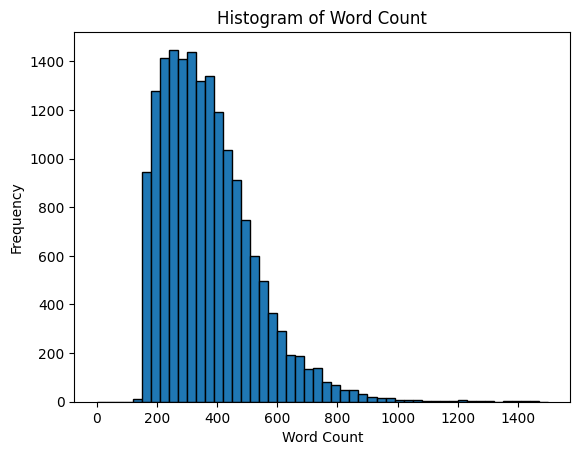

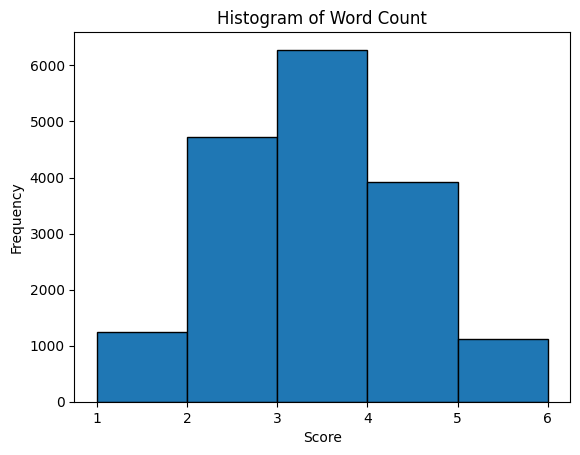

In [136]:

# Plot histogram of word count
plt.hist(df['essay_word_count'], bins=50, edgecolor='black', range=(0, 1500))
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()

# Plot histogram grades
plt.hist(df['score'], bins=5, edgecolor='black')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.show()


Due to the imbalanced nature of the assigned scores, we will utilize Random Under Sampling to reduce the size of the majority class (3), and test if it improves or worsens our model.

In [137]:
#Label encode some of the categorical features (maybe we try one-hot encoding too?)

le = LabelEncoder() #encodes the target variable

toEncode = ['assignment', 'prompt_name', "economically_disadvantaged", 'student_disability_status', 'ell_status', 'race_ethnicity', 'gender'] 

for item in toEncode:
   df[item] = le.fit_transform(df[item])

   print(f"\n{item} mapping:") #prints out what category converted to what integer
   for i, label in enumerate(le.classes_):
      print(f"{i} -> {label}")



assignment mapping:
0 -> In "The Challenge of Exploring Venus," the author suggests studying Venus is a worthy pursuit despite the dangers it presents. Using details from the article, write an essay evaluating how well the author supports this idea. Be sure to include: a claim that evaluates how well the author supports the idea that studying Venus is a worthy pursuit despite the dangers; an explanation of the evidence from the article that supports your claim; an introduction, a body, and a conclusion to your essay.
1 -> In the article "Making Mona Lisa Smile," the author describes how a new technology called the Facial Action Coding System enables computers to identify human emotions. Using details from the article, write an essay arguing whether the use of this technology to read the emotional expressions of students in a classroom is valuable.
2 -> In the article “Driverless Cars are Coming,” the author presents both positive and negative aspects of driverless cars. Using details 

C:\Users\danqw\AppData\Local\Temp\ipykernel_1376\676827218.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


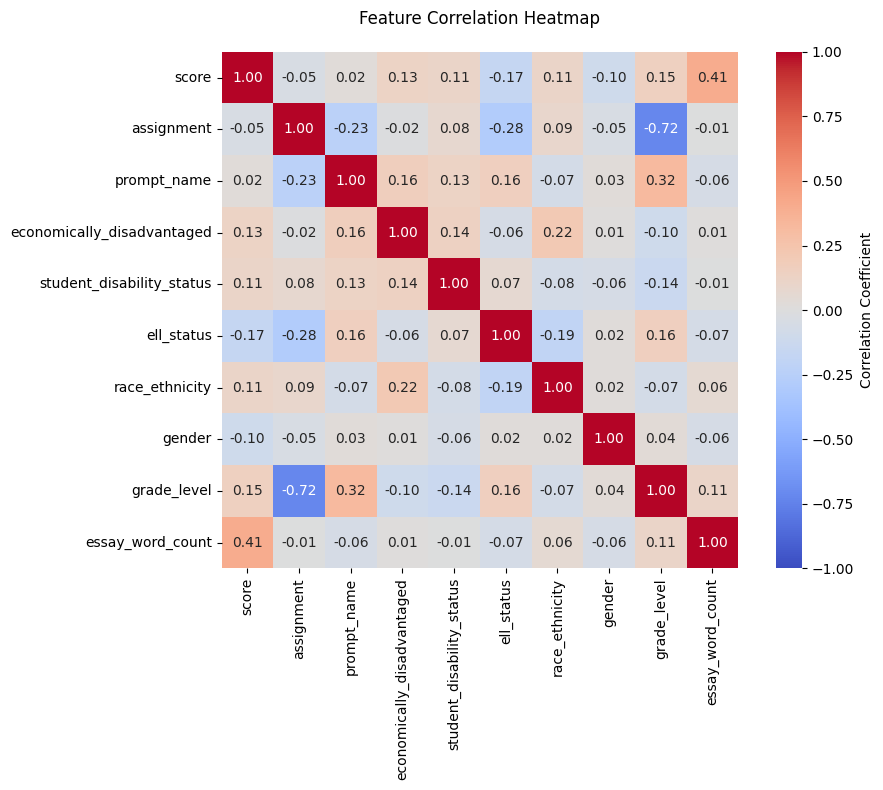

In [138]:
corr_matrix = df.corr()

# Create f  igure and axis
plt.figure(figsize=(10, 8))

# Create heatmap
sns.heatmap(
    corr_matrix,
    annot=True,  # Show correlation values
    cmap='coolwarm',  # Blue-red diverging colormap
    center=0,  # Center the colormap at 0
    vmin=-1,  # Minimum correlation value
    vmax=1,   # Maximum correlation value
    fmt='.2f',  # Format correlation values to 2 decimal places
    square=True,  # Make the plot square-shaped
    cbar_kws={'label': 'Correlation Coefficient'}
)

# Customize the plot
plt.title('Feature Correlation Heatmap', pad=20)
plt.tight_layout()

The correlation heat map shows nothing of significance. It seems that essay_word_count and score are moderately positively correlated, suggesting that higher word count essays got higher scores. It also shows that assignment and grade_level are decently negatively correlated, suggesting that lower students in lower grades tended to get the essays that were encoded to high numbers, which does not provide any insights.